# 🚀 PPE Vision 360 — BERT Classifier Enhancement (Post-FAISS Retrieval)

## 📌 Project Context
PPE Vision 360 is our AI-driven safety compliance MVP designed to ensure workers follow safety rules.  
We already use **FAISS** for fast semantic search — this lets us quickly retrieve relevant safety Q&A or instructions from our stored knowledge base.

Now, we are **adding BERT** (Bidirectional Encoder Representations from Transformers) to **classify** text inputs after FAISS retrieval.  
This will give the system the ability to understand **the type of request or statement** and take context-aware actions.

---

## 🎯 Why Add BERT After FAISS?

- **FAISS Role** → Finds *most similar* stored entries to a query.
- **BERT Role** → Understands *meaning* and classifies the input into a specific category.

Example flow:
1. Worker sends a question or statement.
2. FAISS finds similar Q&A from the database.
3. **BERT** determines if it’s:
   - A safety compliance check
   - A violation report
   - A request for PPE recommendation
4. System responds or triggers the correct action.

---

## 🧠 What is BERT?
BERT is a deep learning language model trained on huge amounts of text.  
It:
- Reads text in **both directions** at the same time (bidirectional)
- Understands **context** (e.g., "bat" in sports vs "bat" in animals)
- Is great for **classification, intent detection, and text understanding**

---

## 🔍 Why BERT Over Traditional Models (e.g., SVM, Naive Bayes)?
- **Understands context**, not just keywords
- **Pretrained knowledge** — needs less data for good results
- Can handle **multi-class** and **multi-label** classification
- Works well with **small datasets** when fine-tuned

---

## 🛠 Types of BERT Models
- **bert-base-uncased** → Standard size, lowercase text (good default)
- **distilbert-base-uncased** → Smaller & faster, good for MVPs
- **albert-base-v2** → Even smaller and memory-efficient
- **Domain-specific BERT** → e.g., BioBERT (medical), FinBERT (finance)

For PPE Vision 360 MVP → we will start with **bert-base-uncased** or **distilbert-base-uncased**.

---

## 📋 Colab Plan — Step by Step

1. **Install Libraries**
   - Transformers (Hugging Face)
   - TensorFlow/Keras

2. **Load Dataset**
   - Multi-class CSV file (text + label)
   - Convert labels to integers for training

3. **Tokenize Text**
   - Use `BertTokenizer` to convert sentences into BERT’s token IDs
   - Add `[CLS]` and `[SEP]` automatically

4. **Create TensorFlow Datasets**
   - Wrap tokenized inputs & labels in `tf.data.Dataset` for efficient training

5. **Load Pretrained BERT Model**
   - `TFBertForSequenceClassification`
   - Specify `num_labels`, `id2label`, `label2id`

6. **Freeze BERT Layers (Optional for MVP)**
   - Train only the classification head to avoid overfitting with small dataset

7. **Compile Model**
   - Adam optimizer (low learning rate, e.g., 5e-5)
   - SparseCategoricalCrossentropy loss

8. **Train**
   - Fit for 2–3 epochs (monitor validation accuracy)

9. **Save Model + Tokenizer**
   - Use `.save_pretrained()` so they can be reloaded in VSCode/Streamlit

10. **Test Inference**
    - Use `pipeline("text-classification")` to verify predictions

11. **Integrate with Streamlit**
    - Load saved model in `pipeline`
    - Classify user inputs after FAISS retrieval
    - Route outputs to different actions in PPE Vision 360

---

## ✅ Expected Outcome
- **Enhanced PPE Vision 360 intelligence** — not just retrieving info (FAISS), but understanding *intent and category* of inputs
- **Fast MVP deployment** — BERT fine-tuned with small dataset, frozen layers for efficiency
- **Future-ready pipeline** — Easy to swap in a faster/smaller BERT model for production

---


#### 1. Install Libraries

In [1]:
!pip install transformers


In [2]:

import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


In [3]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split


#### 2. Load Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/PPE-Vision/datasets/nlp/Bert classifier/bert_multiclass_ppe_dataset.csv")
df.head()


,text,label
0,No gloves worn while handling chemicals.,PPE_NonCompliance
1,How to call site emergency services?,Emergency_Response
2,Safe ladder usage guidelines.,Safety_Procedure
3,How to operate fire extinguisher correctly?,Safety_Procedure
4,Lack of protective boots in hazardous area.,PPE_NonCompliance


#### 3. Tokenize Text

In [5]:
label2id = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
id2label = {idx: label for label, idx in label2id.items()}
df['label_id'] = df['label'].map(label2id)


In [6]:
df.head()

,text,label,label_id
0,No gloves worn while handling chemicals.,PPE_NonCompliance,3
1,How to call site emergency services?,Emergency_Response,0
2,Safe ladder usage guidelines.,Safety_Procedure,4
3,How to operate fire extinguisher correctly?,Safety_Procedure,4
4,Lack of protective boots in hazardous area.,PPE_NonCompliance,3


In [7]:
df["label_id"].unique()

array([3, 0, 4, 1, 2])

In [8]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label_id'].tolist(), test_size=0.2, random_state=42
)


In [9]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding="max_length", max_length=128, return_tensors='tf')
val_encodings   = tokenizer(val_texts,   truncation=True, padding="max_length", max_length=128, return_tensors='tf')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


#### 4. Create TensorFlow Datasets

In [10]:


# Remove token_type_ids (DistilBERT doesn't need them)
train_dataset = (
    tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": train_encodings["input_ids"],
            "attention_mask": train_encodings["attention_mask"]
        },
        train_labels
    ))
    .shuffle(1000)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": val_encodings["input_ids"],
            "attention_mask": val_encodings["attention_mask"]
        },
        val_labels
    ))
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)


#### 5. Load Pretrained BERT Model

In [11]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    from_pt=True # <- forces loading from PyTorch weights
)


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSeq

#### 6. Freeze BERT Layers and Unfreeze the Last layers

In [12]:
# Freeze all first
for layer in model.distilbert.transformer.layer:
    layer.trainable = False

for layer in model.distilbert.transformer.layer[:1]:
    layer.trainable = True

#### 7.Compile Model

In [13]:
model.compile(

      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics = ['accuracy']
)


#### 8. Callbacks

In [14]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
]



#### 9.Train

In [15]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=callbacks)

Epoch 1/5
5/5 [==============================] - 35s 2s/step - loss: 1.5926 - accuracy: 0.2875 - val_loss: 1.5857 - val_accuracy: 0.2000
Epoch 2/5
5/5 [==============================] - 3s 693ms/step - loss: 1.4876 - accuracy: 0.4625 - val_loss: 1.4852 - val_accuracy: 0.2000
Epoch 3/5
5/5 [==============================] - 2s 446ms/step - loss: 1.3664 - accuracy: 0.5000 - val_loss: 1.3785 - val_accuracy: 0.6000
Epoch 4/5
5/5 [==============================] - 3s 728ms/step - loss: 1.2169 - accuracy: 0.6500 - val_loss: 1.2545 - val_accuracy: 0.7000
Epoch 5/5
5/5 [==============================] - 4s 987ms/step - loss: 1.0540 - accuracy: 0.8125 - val_loss: 1.0991 - val_accuracy: 0.9500


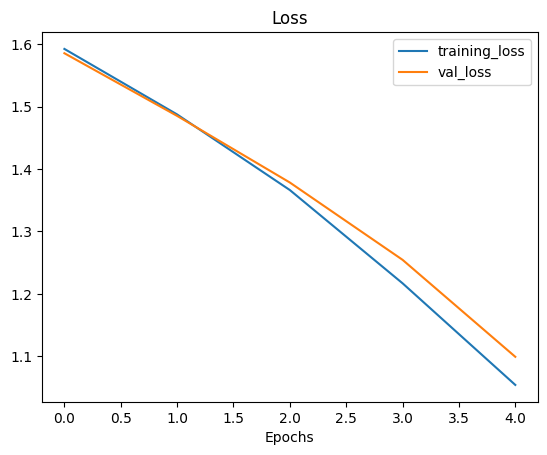

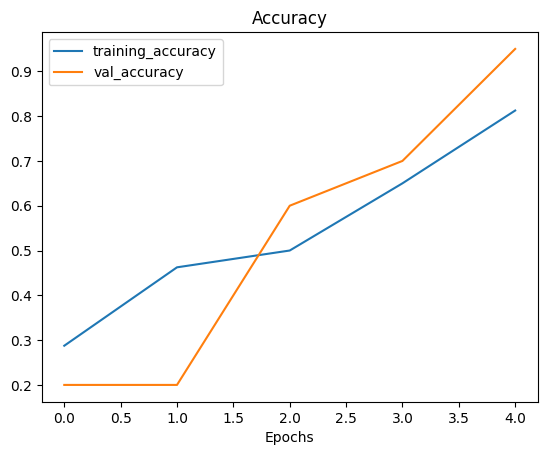

In [16]:
plot_loss_curves(history)

#### 10. Save Model + Tokenizer

In [17]:
model.save_pretrained("saved_bert")
tokenizer.save_pretrained("saved_bert")


('saved_bert/tokenizer_config.json',
 'saved_bert/special_tokens_map.json',
 'saved_bert/vocab.txt',
 'saved_bert/added_tokens.json',
 'saved_bert/tokenizer.json')

In [18]:
import os
import shutil
import zipfile

# Define the directory where you want to save the model
save_dir = "saved_bert"

# Create a zip file of the saved model folder
zip_filename = "distilbert_model.zip"
shutil.make_archive(base_name=zip_filename.replace('.zip', ''), format='zip', root_dir=save_dir)

print(f"Model saved and zipped as {zip_filename}")

Model saved and zipped as distilbert_model.zip


##### 11. Using Dropout

In [19]:
import tensorflow as tf
from transformers import TFAutoModel

num_labels = len(label2id)
dropout_rate = 0.4 # e.g., 30%

# Load base model without classification head
base_model = TFAutoModel.from_pretrained("distilbert-base-uncased", from_pt=True)

# Freeze layers (all except last transformer block)
for layer in base_model.distilbert.transformer.layer:
    layer.trainable = False


# Define inputs
input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name="attention_mask")

# Get outputs
outputs = base_model(input_ids, attention_mask=attention_mask)[0]
cls_token = outputs[:, 0, :]

# Add dropout
x = tf.keras.layers.Dropout(dropout_rate)(cls_token)

# Classification head
logits = tf.keras.layers.Dense(num_labels)(x)

# Build model
model_1 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=logits)

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [20]:
history_1 = model_1.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=callbacks)

Epoch 1/5
5/5 [==============================] - 24s 2s/step - loss: 1.8705 - accuracy: 0.2375 - val_loss: 0.8967 - val_accuracy: 0.6000
Epoch 2/5
5/5 [==============================] - 2s 359ms/step - loss: 0.8880 - accuracy: 0.6750 - val_loss: 0.2562 - val_accuracy: 0.9500
Epoch 3/5
5/5 [==============================] - 1s 239ms/step - loss: 0.4779 - accuracy: 0.8750 - val_loss: 1.3307 - val_accuracy: 0.7500
Epoch 4/5
5/5 [==============================] - 1s 245ms/step - loss: 0.3394 - accuracy: 0.8875 - val_loss: 0.2482 - val_accuracy: 0.8500
Epoch 5/5
5/5 [==============================] - 1s 271ms/step - loss: 0.1696 - accuracy: 0.9625 - val_loss: 0.0552 - val_accuracy: 1.0000


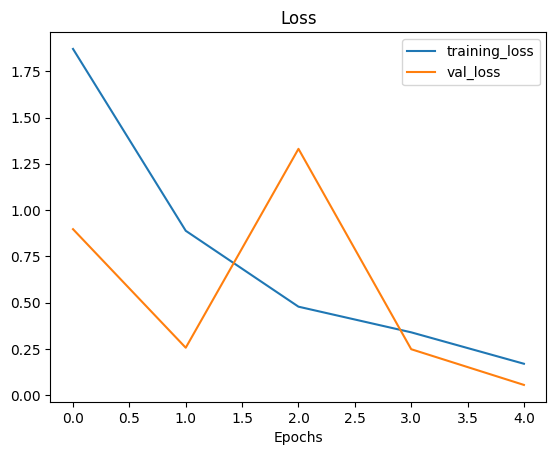

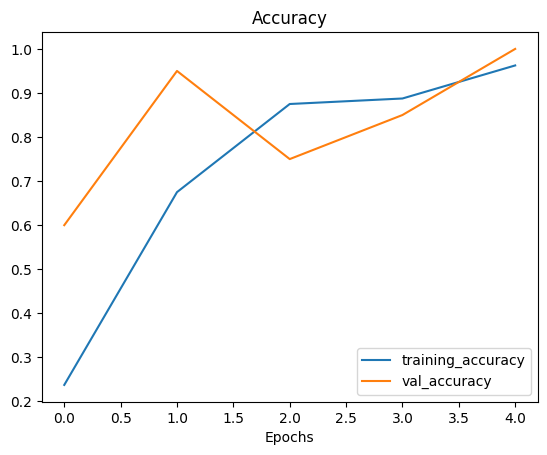

In [21]:
plot_loss_curves(history_1)

#### 12. Load Model

In [23]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

model = TFAutoModelForSequenceClassification.from_pretrained("saved_bert")
tokenizer = AutoTokenizer.from_pretrained("saved_bert")


Some layers from the model checkpoint at saved_bert were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_bert and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 13. Test inference

In [24]:
from transformers import pipeline

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, framework='tf')

print(classifier("This is an example sentence to classify."))


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Device set to use 0


[{'label': 'Hazard_Reporting', 'score': 0.2549267113208771}]


# PPE Vision 360 — MVP Summary

## What We Built  
We developed a comprehensive MVP for **PPE Vision 360**, an AI-driven system designed to improve safety compliance by detecting and classifying Personal Protective Equipment (PPE) from images and text.

### Key Components:
- **Object Detection & Segmentation:**  
  Used state-of-the-art models (e.g., YOLO, EfficientNet) to detect and segment PPE items (helmets, gloves, vests, boots) in images with high accuracy.
  
- **Image Classification:**  
  Built classifiers to verify whether detected PPE is compliant (good condition) or non-compliant (damaged or missing).

- **Chatbot with FAISS:**  
  Implemented a chatbot that leverages FAISS (Facebook AI Similarity Search) for fast and relevant retrieval of OSHA-related safety Q&A and guidelines.

- **Text Classification with BERT:**  
  Fine-tuned a DistilBERT model for classifying PPE-related textual data to assist in compliance checks and reporting.

## MVP Capabilities  
- End-to-end pipeline from image input through detection, segmentation, and classification.
- Interactive chatbot providing instant responses based on safety regulations and PPE compliance queries.
- Text-based PPE classification model integrated for richer context understanding.
- Ready for integration into user-friendly interfaces such as Streamlit apps.

## Potential Improvements & Next Steps  
- **Expand Dataset:**  
  Collect and label more diverse and real-world images and text samples to improve model robustness.

- **Model Fine-tuning & Optimization:**  
  Experiment with unfreezing more layers, longer training, and model compression techniques for better performance and faster inference.

- **Multi-Modal Fusion:**  
  Combine image and text data for more accurate and contextual PPE compliance assessment.

- **Advanced Chatbot Features:**  
  Enhance chatbot capabilities with more conversational AI features and continuous learning.

- **Deployment & Scalability:**  
  Build scalable APIs, cloud deployment pipelines, and monitoring systems for real-time industrial use.

- **UI/UX Enhancements:**  
  Develop comprehensive dashboards for compliance reporting and alerts to improve user experience.

- **Continuous Improvement:**  
  Implement data pipelines for ongoing data collection, retraining, and model updates to adapt to changing environments.

---

This MVP demonstrates a practical and scalable approach to improving workplace safety compliance using AI technologies.

